# Init

In [1]:
try:
    import os
    import glob
    import sys
    import math
    from typing import List, Optional
    from functools import partial
    import itertools
    import copy
except Exception as e:
    print(e)
    print("Some of the libraries needed to run this script were not installed or were not loaded. Please install the libraries before proceeding.")

In [103]:
sys.path.append(os.environ['DEV_AUTOTS'])
sys.path.append(os.environ['CAPSTONE_PYTHON_SOURCE'])
folder = os.environ['CAPSTONE_DATA']

In [104]:
try:
    # Data Tables
    import pandas as pd
    import numpy as np

    # Plotting
    import matplotlib.pyplot as plt
    import plotly.offline as py
    from plotly.offline import plot
    py.init_notebook_mode(connected=True)

    # EDA and Feature Engineering
    from scipy.spatial.distance import euclidean, pdist, squareform
    import statsmodels.api as sm

    # Auto Time Series
    import auto_ts as AT

    # Optimizer
    from skopt import gp_minimize
    from skopt.space import Real, Integer
    from skopt.plots import plot_convergence
except Exception as e:
    print(e)
    print("Some of the libraries needed to run this script were not installed or were not loaded. Please install the libraries before proceeding.")

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
try:
    from ETL.ETL import loadDataset, getTopProducts
    from similarity.similarity import mergeTopSimilar, loadSimilarity
    from charting.charting import surface3DChart
except Exception as e:
    print(e)
    print("Some of the libraries needed to run this script were not installed or were not loaded. Please install the libraries before proceeding.")    

In [107]:

dataRaw= loadDataset(version=4)
dfSimilarity = loadSimilarity(version=4)

In [108]:
dataRaw['Chain Master'].unique()

array(['THE BARREL HOUSE', 'WESTERN BEV LIQ TX', 'SPECS'], dtype=object)

# Prep Data

In [109]:
#Parameters
ChainMaster = 'SPECS'
ProdCat='SUP PREM WHISKEY'
TOP_PRODUCTS = 3  # How many products to consider in the category
TOP_SIMILAR = 1  # Get TOP_SIMILAR most similar products

LOG_TRANSFORM = True # Take log of 9L cases to smooth out peaks and valleys
ZERO_ADDER = 0.1 

RESAMPLE_FREQ = 'M'

# Pricing changes every 4 weeks
if RESAMPLE_FREQ == 'M':
    FORECAST_PERIOD = 1
if RESAMPLE_FREQ == 'W':
    FORECAST_PERIOD = 4 
if RESAMPLE_FREQ == '2W':
    FORECAST_PERIOD = 2 

# Seasonal Period
if RESAMPLE_FREQ == 'M':
    SEASONAL_PERIOD = 12  # Yearly
if RESAMPLE_FREQ == 'W':
    SEASONAL_PERIOD = 13 # Quarterly (we can also take yearly = 52, but SARIMAX becomes too slow)
if RESAMPLE_FREQ == '2W':
    SEASONAL_PERIOD = 13 # This becomes problematic --> for quarterly, should we take 6 biweekly periods or 7 bi-weekly periods. Instead I just took half yearly period  

print("="*50)
print("Parameters being used...")
print("="*50)
print(f"Resample Frequency = {RESAMPLE_FREQ}")
print(f"Forecast Period = {FORECAST_PERIOD}")
print(f"Seasonal Period = {SEASONAL_PERIOD}")
print(f"Chain: {ChainMaster}")
print(f"Product Category: {ProdCat}")


Parameters being used...
Resample Frequency = M
Forecast Period = 1
Seasonal Period = 12
Chain: SPECS
Product Category: SUP PREM WHISKEY


In [110]:
ProductsList = getTopProducts(dataRaw, ChainMaster=ChainMaster, ProdCat=ProdCat, topN=TOP_PRODUCTS, timeCol='WeekDate')
ProductsList

['JACK DANIELS BLK WHSKY  1L',
 'JACK DANIELS BLK WHSKY  1.75L',
 'JACK DANIELS BLK WHSKY  750M']

Decoder: {'0': 'JACK DANIELS BLK WHSKY  1L', '1': 'JACK DANIELS BLK WHSKY  1.75L', '2': 'JACK DANIELS BLK WHSKY  750M'}



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
Exogenous Price Columns: ['0', '1']
% of weeks without a purchase: 0.0


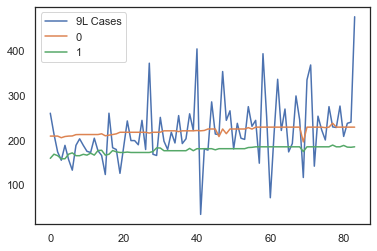




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------
Exogenous Price Columns: ['1', '0']
% of weeks without a purchase: 8.333333333333332


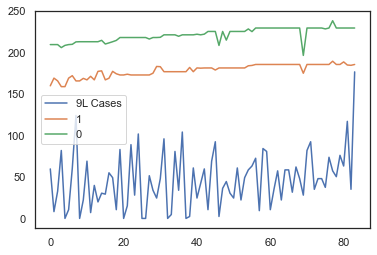




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------
Exogenous Price Columns: ['2', '1']
% of weeks without a purchase: 2.380952380952381


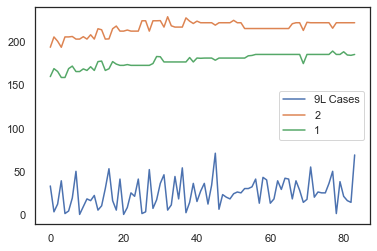

In [111]:
all_data = []

colTime = 'WeekDate'
colPreds = ['9L Cases'] #Demand
colPrice = ['Dollar Sales per 9L Case'] #Price

for i, Product in enumerate(ProductsList):
    # Product = ProductsList[0]
    # colTime = 'WeekDate'
    # colPreds = ['9L Cases'] #Demand
    # colPrice = ['Dollar Sales per 9L Case'] #Price

    #TO DO:
    #Merge top similar only looking at a list of products  DONE
    #Encode before the merge? (same prods same code) DONE
    #one chain, top three products, top 1 similar DONE
    #Impute the price DONE
    (dataModel,colExog,colEnc,colDec) = mergeTopSimilar(dataRaw, dfSimilarity
                                                        ,ChainMaster=ChainMaster
                                                        ,Product=Product
                                                        ,ProductsList=ProductsList
                                                        ,topn=TOP_SIMILAR 
                                                        ,periodCol = colTime
                                                        ,resampleFreq=RESAMPLE_FREQ
                                                        ,encodeCols=True)
                                                                            
    
    if i == 0:
        print(f"Decoder: {colDec}")

    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    
    #colExog = colExog + colEndog
    print(f"Exogenous Price Columns: {colExog}")
    
    allCols=[colTime]+colPreds+ colExog
    data=dataModel[allCols]
    print(f"% of weeks without a purchase: {sum(data['9L Cases'] == 0)/data.shape[0]*100}")
    # print(data.tail(5))
    data.iloc[:][data.columns[-(TOP_SIMILAR+2):]].plot()
    all_data.append(data)
    plt.show()




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------


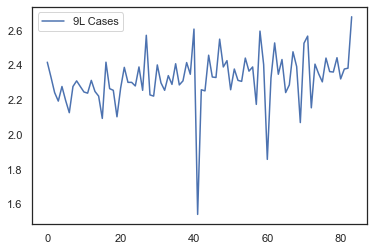




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------


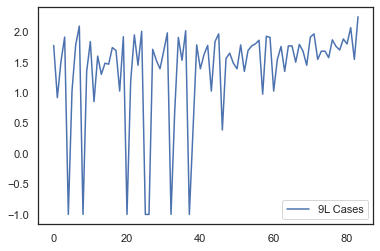




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------


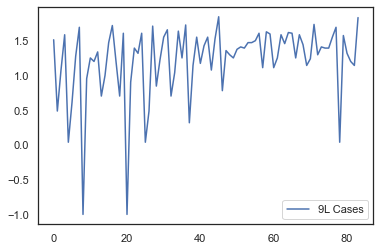

In [112]:
# Input Transformation

all_data_non_transformed =  copy.deepcopy(all_data)
    
if LOG_TRANSFORM: 
    for i in np.arange(len(all_data)):
        all_data_non_transformed[i] = all_data[i].copy(deep=True)
        all_data[i][colPreds] = np.log10(all_data[i][colPreds] + ZERO_ADDER)
        print("\n\n")
        print("-"*50)
        print(f"Product: {colDec.get(str(i))}")
        print("-"*50)
        
        all_data[i].iloc[:][colPreds].plot()
        plt.show()    

In [113]:
# Checks
for i in np.arange(len(all_data)):
    print(i)
    assert((np.log10(all_data_non_transformed[i][colPreds]+ZERO_ADDER) == all_data[i][colPreds]).all().values[0])    

0
1
2


# Test for White Noise

In [114]:
white_noise_all = []
white_noise_df_all = []

for i, data in enumerate(all_data):
    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    white_noise_df = sm.stats.acorr_ljungbox(data[colPreds], lags=[12,24, 48], return_df=True)
    white_noise_df_all.append(white_noise_df)
    if any(white_noise_df['lb_pvalue'] > 0.05):
        white_noise = True
    else:
        white_noise = False
    white_noise_all.append(white_noise)
    
    print(white_noise_df)
    print(f"\nIs Data White Noise: {white_noise}")





--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
      lb_stat  lb_pvalue
12  15.190957   0.231159
24  26.538512   0.326419
48  48.667832   0.445959

Is Data White Noise: True



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------
      lb_stat  lb_pvalue
12  29.265420   0.003598
24  41.411630   0.015005
48  54.239869   0.248702

Is Data White Noise: True



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------
      lb_stat  lb_pvalue
12  26.913026   0.007953
24  38.221972   0.032900
48  54.395929   0.244080

Is Data White Noise: True


# Model

In [115]:
all_train = []
all_test = []
all_models = []

all_train_non_transformed = []
all_test_non_transformed = []

for i, data in enumerate(all_data):
    train = all_data_non_transformed[i].iloc[:-FORECAST_PERIOD]
    test = all_data_non_transformed[i].iloc[-FORECAST_PERIOD:]
    all_train_non_transformed.append(train)
    all_test_non_transformed.append(test)

    train = data.iloc[:-FORECAST_PERIOD]
    test = data.iloc[-FORECAST_PERIOD:]
    all_train.append(train)
    all_test.append(test)

    print(train.shape,test.shape)

(83, 4) (1, 4)
(83, 4) (1, 4)
(83, 4) (1, 4)


In [116]:
# Checks
for i in np.arange(len(all_data)):
    print(i)
    assert((np.log10(all_train_non_transformed[i][colPreds]+ZERO_ADDER) == all_train[i][colPreds]).all().values[0])
    assert((np.log10(all_test_non_transformed[i][colPreds]+ZERO_ADDER) == all_test[i][colPreds]).all().values[0])

0
1
2


In [117]:
for i, data in enumerate(all_data):
    train = all_train[i]
    test = all_test[i]

    automl_model = AT.AutoTimeSeries(
        score_type='rmse', forecast_period=FORECAST_PERIOD, # time_interval='Week',
        non_seasonal_pdq=None, seasonality=True, seasonal_period=SEASONAL_PERIOD,
        model_type=['SARIMAX','ML'],
        verbose=0)
    automl_model.fit(train, 'WeekDate', '9L Cases', ',')
    automl_model.get_leaderboard()
    all_models.append(automl_model)

Start of Fit.....
    Target variable = 9L Cases
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
    Dataframe loaded successfully. Shape of data set = (83, 3)
Time Interval of obserations has not been provided. Program will try to figure this out now...
Time series input in days = 28
It is a Monthly time series.


Building SARIMAX Model



Running Seasonal SARIMAX Model...
Shape (manual split): (82, 3) (1, 3)
Shape using CV: (82, 3) (1, 3)
Building a Seasonal Model...

    Finding best Non-Seasonal pdq Parameters:

Differencing = 0 with Seasonality = False
    Iteration 0 completed...
    Best AR order p = 0, MA order q = 1, Interim metric = -80.076

Differencing = 1 with Seasonality = True
    D = 1 results in an empty ARMA set. Setting Seasonality to False since model might overfit

    Finding best Seasonal PDQ Model Parameters:

Differencing = 0 with Seasonality = True
    Iteration 0 completed...
    Best AR order p = 1, MA order q = 0, Interim 

In [118]:
for i in np.arange(len(all_data)):
    print("\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    print("\nLeaderboard")
    print(all_models[i].get_leaderboard())



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------

Leaderboard
      name      rmse
0  SARIMAX  0.027766
1       ML  0.086814


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------

Leaderboard
      name      rmse
1       ML  0.012649
0  SARIMAX  0.511517


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------

Leaderboard
      name      rmse
0  SARIMAX  0.212365
1       ML  0.212549


# Prediction

In [119]:
for i in np.arange(len(all_data)):
    print("\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    print("\nTest Data (Original)")
    print(all_test_non_transformed[i])
    print("\nTest Data (Transformed)")
    print(all_test[i])
    
    test_predictions = all_models[i].predict(X_exogen = all_test[i])
    print("\nBest Prediction (Transformed)")
    print(test_predictions)
    if LOG_TRANSFORM:
        print("\nBest Prediction (Original)")
        test_predictions = 10**test_predictions
        print(test_predictions)
    
    
    test_predictions = all_models[i].predict(X_exogen = all_test[i], model='ML')  
    print("\nML Predictions (Transformed)")
    print(test_predictions)
    if LOG_TRANSFORM:
        print("\nML Predictions (Original)")
        test_predictions = 10**test_predictions
        print(test_predictions)
    
    print("\nSARIMAX Predictions (Transformed)")
    test_predictions = all_models[i].predict(X_exogen = all_test[i], model='SARIMAX') 
    print(test_predictions)
    if LOG_TRANSFORM:
        print("\nSARIMAX Predictions (Original)")
        test_predictions = 10**test_predictions
        print(test_predictions)




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------

Test Data (Original)
     WeekDate  9L Cases           0           1
83 2019-12-31    476.14  229.533835  185.589744

Test Data (Transformed)
     WeekDate  9L Cases           0           1
83 2019-12-31  2.677826  229.533835  185.589744

Best Prediction (Transformed)
2.3654790275750304

Best Prediction (Original)
231.99521505352232

ML Predictions (Transformed)
0    2.294897
Name: mean, dtype: float64

ML Predictions (Original)
0    197.195521
Name: mean, dtype: float64

SARIMAX Predictions (Transformed)
2.3654790275750304

SARIMAX Predictions (Original)
231.99521505352232


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------

Test Data (Original)
     WeekDate  9L Cases           1           0
83 2019-12-31    176.67  185.589744  229.533835

Test Data (Trans

# Optimizer

In [120]:
def complex_objective(x: List, mask: Optional[List[bool]] = None, verbose: int = 0, return_individual: bool = False, logT = False):
    """
    :param x A list of product pricing for which the revenue has to be computed
    :type x List
    :param mask: If the customer is not going to purchase a product in a period, we can choose to omit it from the revenue calculation in the optimizer.
                 Default = None (considers all products in revenue calculation)
    :type mask  Optional[List[bool]]
    :param return_individual If True, this returns the individual revenue values as well
                             Used mainly when this function is called standalone. Set of False for optimization
    :type return_individual bool
    :param verbose Level of verbosity (Default: 0). This is set to 1 or 2 (mainly for debug purposes)
    """

    index = [str(i) for i in np.arange(len(x))]
    x_df = pd.DataFrame(x, index = index)
    x_df = x_df.T

    # If mask is not provided, use all
    if mask is None:
        mask = [False for item in x] 

    if verbose >= 2:
        print(x_df.info())
        print(x_df.columns)

    total_revenue = 0
    revenue = []

    for i in np.arange(len(all_data)):
        if verbose >= 1:
            print("\n" + "-"*50)
            print(f"Product Index: {i}")
        
        if not mask[i]:
            columns = all_data[i].columns[-(TOP_SIMILAR+1):].values
            if verbose >= 2:
                print(f"All Columns in Test Data: {columns}")

            test_data = x_df[columns]
            prediction = all_models[i].predict(X_exogen = test_data)
            
            if verbose >= 2:
                print(f"Prediction Type: {type(prediction)}")
            if verbose >= 1:
                print(f"Demand Prediction (transformed): {prediction}")

            # If model was created with log transformation
            if logT:
                prediction = 10**prediction
                if verbose >= 1:
                    print("\nDemand Prediction (Original)")
                    print(prediction)
                
            product_revenue = prediction * x[i]

            # TODO: Clamping - Fix later (this gives an error with pandas. We need to pluck it out as a value)
            # product_revenue = max(product_revenue, 0)  # Clamp at min value of 0 for predictions that are negative

            if verbose >= 1:
                print(f"Product Revenue: ${round(product_revenue)}")
                                
            if isinstance(product_revenue, pd.Series):
                product_revenue = product_revenue.iloc[0]
            revenue.append(product_revenue)
                
            # total_revenue = total_revenue + product_revenue
        else:
            if verbose >= 1:
                print("This product's revenue was not included since it was not ordered by the customer in this period.")
            product_revenue = 0
            revenue.append(product_revenue)

        if verbose >= 1:
            print("-"*50 + "\n")
        
    total_revenue = sum(revenue)

    if verbose >= 1:
        print("\n\n" + "="*50)
        print(f"Total Revenue: ${round(total_revenue)}")
        print("="*50 + "\n\n")

    if return_individual is True:
        return -total_revenue, revenue      

    return -total_revenue
    

In [121]:
# Did the customer actually want to but products in that period?
# Only include the revenue in the objective if they actually ordered it
# This model is not trying to predict if they would purchase a product when they were not going to purchase it earlier.
# That requires a lot of human psychology and may not be captured in the model

INCLUDE_MASKING = True

mask: List[bool] = []
for index in np.arange(len(all_data)):
    if INCLUDE_MASKING:
        if all_test[index].iloc[0]['9L Cases'] == 0:
            mask.append(True)
        else:
            mask.append(False)
    else:
        mask.append(False)

print(f"Mask: {mask}")

Mask: [False, False, False]


In [122]:
MARGIN = 0.0 # How much to go over or under the min and max price respectively during the search for optimial revenue
space = []

for index in np.arange(len(all_data)):
    min_val = all_data[index][str(index)].min()
    max_val = all_data[index][str(index)].max()
    min_limit = min_val*(1-MARGIN)
    max_limit = max_val*(1+MARGIN)
    # print(min_val, max_val)
    # print(min_limit, max_limit)
    space.append(Real(low=min_limit, high=max_limit, prior='uniform'))

space

[Real(low=196.51221804511277, high=238.29562345169282, prior='uniform', transform='identity'),
 Real(low=158.86324786324786, high=189.49694749694748, prior='uniform', transform='identity'),
 Real(low=193.91, high=229.32, prior='uniform', transform='identity')]

In [123]:
# create a new function with mask
masked_complex_objective = partial(complex_objective, mask=mask, logT=LOG_TRANSFORM)
print(f"Revenue without masking: ${-round(complex_objective([266.51, 195.06, 205.3], logT=LOG_TRANSFORM))}")
print(f"Revenue with masking: ${-round(masked_complex_objective([266.51, 195.06, 205.3]))}")

Revenue without masking: $120161.0
Revenue with masking: $120161.0


In [124]:
res = gp_minimize(masked_complex_objective,   
                  space,                      
                  acq_func="EI",              
                  n_calls=200,                
                  n_random_starts=20,  
                  random_state=42)     

In [125]:
print(f"Optimal Price for All Products ($): {[round(price, 2) for price in res.x]} \nMaximum Revenue Expected: ${round(-res.fun)}")
_, all_revenue = masked_complex_objective(res.x, return_individual=True)
print(f"Individual Optimized Revenue: {all_revenue}")

Optimal Price for All Products ($): [236.73, 186.2, 218.21] 
Maximum Revenue Expected: $71404.0
Individual Optimized Revenue: [59971.899405716176, 6365.965545713834, 5066.1019567241565]


In [126]:
# 3. Reserve a test set - compute revenue from test set and compare to the one from the optimizer
# This is only for the 1st entry in the test set

total_test_data_revenue = 0
for index in np.arange(len(all_data)):
    product_price = all_test_non_transformed[index].iloc[0][str(index)]
    product_demand = all_test_non_transformed[index].iloc[0]['9L Cases']
    product_revenue = product_price * product_demand
    print(f"Product {index} Price 9L Case: ${round(product_price,2)} Revenue: ${round(product_revenue)}")
    total_test_data_revenue = total_test_data_revenue + product_revenue
    
print(f"Total Revenue: ${round(total_test_data_revenue)}")

# Also, some things dont make sense.
# The models are grosely underestimating the demand (as can be seen by the predictions above)

Product 0 Price 9L Case: $229.53 Revenue: $109290.0
Product 1 Price 9L Case: $185.59 Revenue: $32788.0
Product 2 Price 9L Case: $222.36 Revenue: $15343.0
Total Revenue: $157421.0


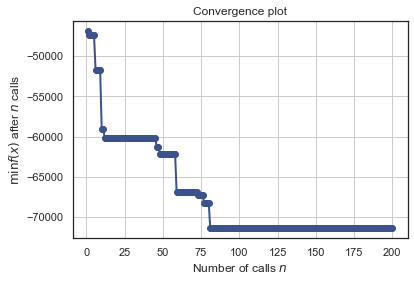

In [127]:
plot_convergence(res)

# TODO

1. Build a baseline model for all products (maybe average of last 2 years (same period) and Compare the performance of automl models to baseline models
2. Compute revenue expected with baseline models and compare to the one from the optimizer
3. [DONE] Reserve a test set - compute revenue from test set and compare to the one from the optimizer
4. [DONE] If using test set, add masking option in optimizer (i.e. if the customer has not purchased a product in that period, then maybe mask out that revenue instead of taking what the model is giving. That should give us a more reasonable estimate.)
5. Add 3D surface plot of revenue vs product pricing (plotly)
6. Consider taking more "similar" products into consideration

In [128]:
math.ceil(space[0].low)
math.floor(space[0].high)
xs = np.arange(math.ceil(space[0].low), math.floor(space[0].high), step=5)
ys = np.arange(math.ceil(space[1].low), math.floor(space[1].high), step=5)

print(xs)
print(ys)

[197 202 207 212 217 222 227 232 237]
[159 164 169 174 179 184]


In [129]:
"".join(ProdCat.split())

'SUPPREMWHISKEY'

In [130]:
filename = "".join(ChainMaster.split()) + "_" + "".join(ProdCat.split()) + "_Top" + str(TOP_PRODUCTS) + "_Sim" + str(TOP_SIMILAR) + \
        "_Log" + str(LOG_TRANSFORM) + "_Add" + str(ZERO_ADDER) + \
        "_Prod" + str(i) + "_Resample" + str(RESAMPLE_FREQ) + "_f" + str(FORECAST_PERIOD) + "_s" + str(SEASONAL_PERIOD) + ".html"
filename

'SPECS_SUPPREMWHISKEY_Top3_Sim1_LogTrue_Add0.1_Prod2_ResampleM_f1_s12.html'

In [131]:
verbose =  1
STEPS = 5

allp = [np.arange(math.ceil(space[i].low), math.floor(space[i].high), step=STEPS) for i in np.arange(len(all_data))] 

if verbose >= 1:
    print("-"*100)
    print(f"Price intervals for product 0: {allp[0]}")
    print(f"Price intervals for product 1: {allp[1]}")
    print(f"Price intervals for product 2: {allp[2]}")
    print("-"*100, "\n")

for i in np.arange(len(all_data)):
    print("\n\n")
    mask_plot = [False if i == j else True for j in np.arange(len(all_data))]
    if verbose >= 1:
        print(f"Product {i} --> Mask: {mask_plot}")

    columns = all_data[i].columns[-(TOP_SIMILAR+1):].values
    if verbose >= 1:
        print(f"Products used in Model: {columns}")
        
    masked_complex_objective_plot = partial(complex_objective, mask=mask_plot, logT=LOG_TRANSFORM, verbose=0)

    finalx = []
    finaly = []
    finalrev = []

    xs = allp[int(columns[0])]  # Main Product Price is in xs
    ys = allp[int(columns[1])]  # Exogenous Product Price in in ys

    if verbose >= 1:
        print(f"Price intervals used for X-axis (product {int(columns[0])}): {xs}")
        print(f"Price intervals used for Y-axis (product {int(columns[1])}): {ys}")
        
    for x, y in itertools.product(xs, ys):
        price_list = [0, 0, 0]
        
        # Fix price for product 0
        if int(columns[0]) == 0:  # If the main product is product 0
            price_list[0] = x
        elif int(columns[1]) == 0: # If exogenous product is product 0
            price_list[0] = y
        else:
            price_list[0] = 0

        # Fix price for product 1
        if int(columns[0]) == 1:  # If the main product is product 1
            price_list[1] = x
        elif int(columns[1]) == 1: # If exogenous product is product 1
            price_list[1] = y
        else:
            price_list[1] = 0

        # Fix price for product 2
        if int(columns[0]) == 2:  # If the main product is product 2
            price_list[2] = x
        elif int(columns[1]) == 2: # If exogenous product is product 2
            price_list[2] = y
        else:
            price_list[2] = 0
       
        rev = -masked_complex_objective_plot(price_list)
        finalx.append(x)
        finaly.append(y)
        finalrev.append(rev)   

    fig = surface3DChart(
        x=finalx, y=finaly, z=finalrev,
        title= 'Product ' + columns[0] + ' Revenue',
        xTitle= 'Product ' + columns[0] + ' Price',
        yTitle= 'Product ' + columns[1] + ' Price',
        width=1200,
        height=800            
        )

    filename = "".join(ChainMaster.split()) + "_" + "".join(ProdCat.split()) + "_Top" + str(TOP_PRODUCTS) + "_Sim" + str(TOP_SIMILAR) + \
        "_Log" + str(LOG_TRANSFORM) + "_Add" + str(ZERO_ADDER) + \
        "_Prod" + str(i) + "_Resample" + str(RESAMPLE_FREQ) + "_f" + str(FORECAST_PERIOD) + "_s" + str(SEASONAL_PERIOD) + ".html"
    py.plot(fig, filename = filename)


----------------------------------------------------------------------------------------------------
Price intervals for product 0: [197 202 207 212 217 222 227 232 237]
Price intervals for product 1: [159 164 169 174 179 184]
Price intervals for product 2: [194 199 204 209 214 219 224]
---------------------------------------------------------------------------------------------------- 




Product 0 --> Mask: [False, True, True]
Products used in Model: ['0' '1']
Price intervals used for X-axis (product 0): [197 202 207 212 217 222 227 232 237]
Price intervals used for Y-axis (product 1): [159 164 169 174 179 184]



Product 1 --> Mask: [True, False, True]
Products used in Model: ['1' '0']
Price intervals used for X-axis (product 1): [159 164 169 174 179 184]
Price intervals used for Y-axis (product 0): [197 202 207 212 217 222 227 232 237]



Product 2 --> Mask: [True, True, False]
Products used in Model: ['2' '1']
Price intervals used for X-axis (product 2): [194 199 204 209 214 219 